# Proteine - proteine interaction graph

groupe :


    - Paul Le Bolloch
    - Ilann Amiaud--Plachy
    - Gaétan Jacquemin


## Introduction

https://snap.stanford.edu/biodata/datasets/10000/10000-PP-Pathways.html

In this notebook we will analyze the Proteine - Proteine interaction graph. The graph is a network of proteins and their interactions. The nodes are proteins and the edges are interactions between them. The graph is undirected and unweighted.

to download the data, you can use the following command:

```bash
mkdir -p data
wget https://snap.stanford.edu/biodata/datasets/10000/files/PP-Pathways_ppi.csv.gz
mv PP-Pathways_ppi.csv.gz data/
```




In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
dataset_path = "./data/PP-Pathways_ppi.csv.gz"

# Read the CSV file with pandas first for better handling of the data
df = pd.read_csv(dataset_path, header=None, compression='gzip' )
df.info()
# df["Individual Side Effect"].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342353 entries, 0 to 342352
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   0       342353 non-null  int64
 1   1       342353 non-null  int64
dtypes: int64(2)
memory usage: 5.2 MB


In [12]:

# Create the directed graph from the dataframe
graph = nx.from_pandas_edgelist(df, source=0, target=1, create_using=nx.DiGraph)    

# Display basic graph statistics
print(f"Number of nodes: {graph.number_of_nodes()}")
print(f"Number of edges: {graph.number_of_edges()}")

Number of nodes: 21557
Number of edges: 342353


95% des nœuds ont un degré <= 132
Degré minimum : 1 (nombre de nœuds : 4183)
Degré maximum : 2132 (nombre de nœuds : 1)
Degré moyen : 31.76


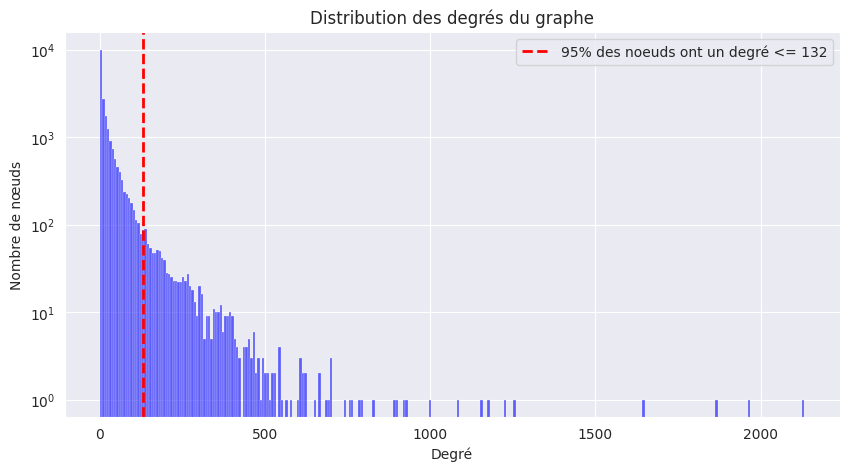

In [61]:
# Calculer les degrés de chaque nœud
degrees = [deg for _, deg in graph.degree()]

# Calcul de 80% des valeurs
degrees = np.array(degrees)
degrees_sorted = np.sort(degrees)
unique_degree, count_degree = np.unique(degrees_sorted, return_counts=True)
cumulative_percentage = np.cumsum(count_degree) / len(degrees)
idx_80 = np.argmax(cumulative_percentage >= 0.95)
print(f"95% des nœuds ont un degré <= {unique_degree[idx_80]}")

# Afficher quelques statistiques
print(f"Degré minimum : {min(degrees)} (nombre de nœuds : {count_degree[unique_degree.argmin()]})")
print(f"Degré maximum : {max(degrees)} (nombre de nœuds : {count_degree[unique_degree.argmax()]})")
print(f"Degré moyen : {np.mean(degrees):.2f}")

# Version seaborn
plt.figure(figsize=(10, 5))
sns.set_style("darkgrid")
sns.histplot(degrees, bins=300, color='blue', log_scale=False, alpha=0.6)
plt.axvline(x=idx_80, color='red', linestyle='--', linewidth=2, label = f"95% des noeuds ont un degré <= {unique_degree[idx_80]}")
# plt.xlim(0, 300)
plt.xlabel("Degré")
plt.ylabel("Nombre de nœuds")
plt.yscale('log')
plt.title("Distribution des degrés du graphe")
plt.legend()
plt.show()

-------------------
Il est intéressant de noter que beaucoup de noeud ont un degré très faible, ce qui signifie que les protéines n'intéragissent pas avec beaucoup d'autres protéines. Cela peut être dû à la nature des protéines, certaines protéines n'ont pas besoin d'intéragir avec beaucoup d'autres protéines pour remplir leur fonction. Cela peut aussi être dû à la qualité des données, il est possible que certaines intéractions n'aient pas été détectées.

-------------------

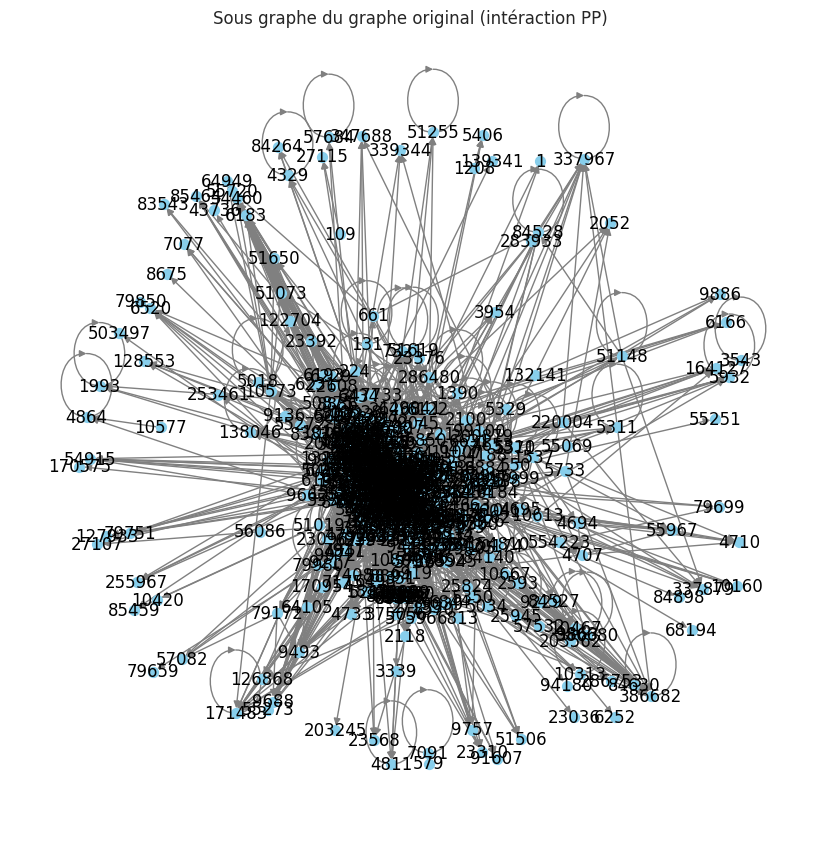

In [22]:
# Extraire un sous-graphe (par exemple les 100 premiers nœuds)
nodes_sample = list(graph.nodes)[:500]
H = graph.subgraph(nodes_sample)

# Visualiser ce sous-graphe
plt.figure(figsize=(8, 8))
nx.draw(H, with_labels=True, node_size=50, node_color='skyblue', edge_color='gray')
plt.title("Sous graphe du graphe original (intéraction PP)")
plt.show()

-----------------
De par la visualisation, on remarque que beaucoup de protéines intéragissent avec elles mêmes. et que les protéines ont tendance à former des groupes de protéines qui intéragissent entre elles.

-----------------

## Centrality

### degree centrality

In [23]:
degree_centrality = nx.degree_centrality(graph)

# Afficher les 5 nœuds les plus centraux
top_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 nœuds par centralité en degré :")
for node, centrality in top_nodes:
    print(f"Nœud {node} -> Centralité : {centrality:.4f}")

Top 5 nœuds par centralité en degré :
Nœud 351 -> Centralité : 0.0989
Nœud 4914 -> Centralité : 0.0912
Nœud 1994 -> Centralité : 0.0866
Nœud 7316 -> Centralité : 0.0764
Nœud 7514 -> Centralité : 0.0583


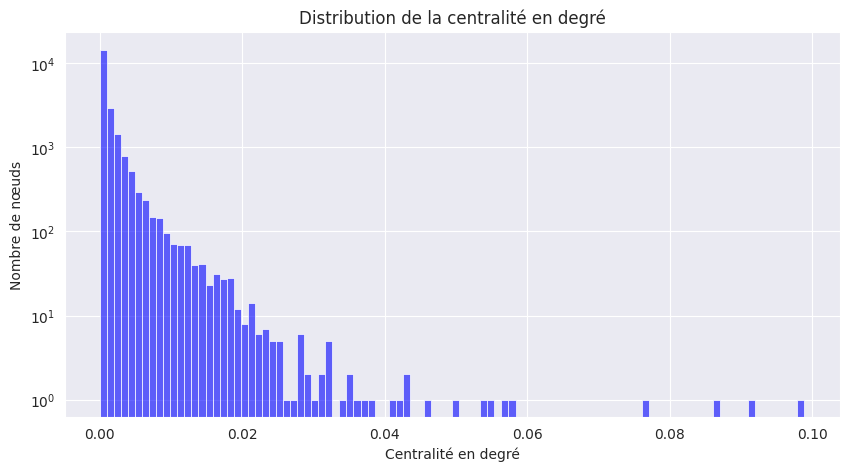

In [26]:
# histogram

plt.figure(figsize=(10, 5))
sns.histplot(list(degree_centrality.values()), bins=100, color='blue', log_scale=False, alpha=0.6)
plt.xlabel("Centralité en degré")
plt.yscale('log')
plt.ylabel("Nombre de nœuds")
plt.title("Distribution de la centralité en degré")
plt.show()

---------------
On voit que les noeuds sont peu centraux en terme de degrés. Seul certains noeuds concentrent jusque 10% des liens. 

---------------

### neighborhood connectivity

Top 5 nœuds par connectivité de voisinage :
Nœud 64428 -> Connectivité de voisinage : 2132.0000
Nœud 79800 -> Connectivité de voisinage : 2132.0000
Nœud 91010 -> Connectivité de voisinage : 2132.0000
Nœud 146956 -> Connectivité de voisinage : 2132.0000
Nœud 51334 -> Connectivité de voisinage : 2132.0000

minimum : 0 (nombre de nœuds : 5708)
moyenne : 148.30788052040685
maximum : 2132.0 (nombre de nœuds : 287


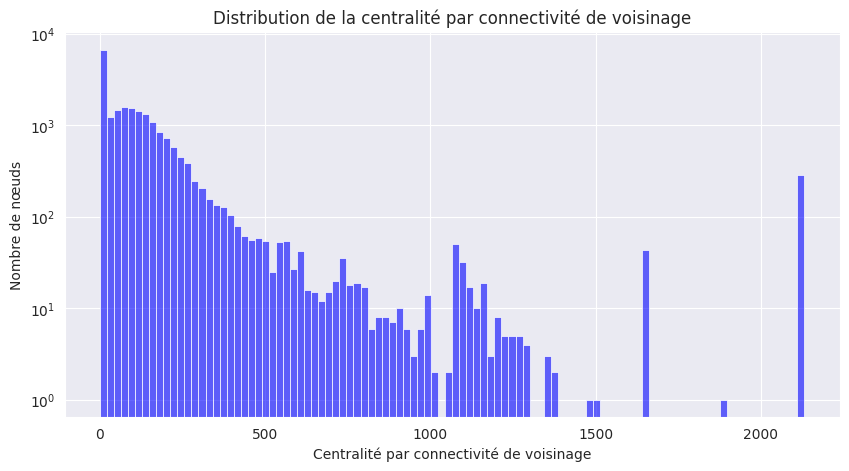

In [38]:
# neighborhood connectivity
degrees = dict(graph.degree())
neighborhood_conn = {}

for node in graph.nodes(): 
    neighbors = list(graph.neighbors(node))
        
    # If node has no neighbors, set neighborhood connectivity to 0
    if not neighbors:
        neighborhood_conn[node] = 0
        continue
        
    # Calculate average degree of neighbors
    neighbor_degrees = [degrees[neighbor] for neighbor in neighbors]
    neighborhood_conn[node] = np.mean(neighbor_degrees)
    
# Afficher les 5 nœuds les plus centraux
top_nodes = sorted(neighborhood_conn.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 nœuds par connectivité de voisinage :")
for node, conn in top_nodes:
    print(f"Nœud {node} -> Connectivité de voisinage : {conn:.4f}")
print("")

centrality_values = neighborhood_conn.values()
print(f"minimum : {min(centrality_values)} (nombre de nœuds : {list(neighborhood_conn.values()).count(min(neighborhood_conn.values()))})")
print(f"moyenne : {np.mean(list(centrality_values))}")
print(f"maximum : {max(centrality_values)} (nombre de nœuds : {list(neighborhood_conn.values()).count(max(neighborhood_conn.values()))}")
    
plt.figure(figsize=(10, 5))
sns.histplot(list(centrality_values), bins=100, color='blue', log_scale=False, alpha=0.6)
plt.xlabel("Centralité par connectivité de voisinage")
plt.yscale('log')
plt.ylabel("Nombre de nœuds")
plt.title("Distribution de la centralité par connectivité de voisinage")
plt.show()


Remarques:

---------------
- on voit que certains noeuds sont capables d'atteindre 100% des autres noeuds seulement par leur voisinage (avec un chemin de taille 2). Cela signifie que ces noeuds sont très centraux en terme de voisinage. 
Ce sont en fait tous les noeuds qui sont connectés au noeud de degré maximum et uniquement à lui, il y en a 287, ces protéines n'intéragissent (selon les connaissances actuelles) qu'avec une seule autre protéine connecté. On peut supposer que cette protéine est très connu et est sur-étudiée dans le domaine (en tout cas dans nos données).

- autre remarques, 5708 noeuds n'ont pas de voisinage autre que eux même, cela signifie que ces noeuds sont isolés et ne sont pas connectés à d'autres noeuds. On peut imaginer les supprimer de notre étude pour accélerer la recherche de communautés.

---------------


### Eigenvector centrality

Top 5 nœuds par centralité de vecteur propre :
Nœud 7307 -> Centralité : 0.1189
Nœud 6202 -> Centralité : 0.1129
Nœud 6194 -> Centralité : 0.1127
Nœud 351 -> Centralité : 0.1077
Nœud 6201 -> Centralité : 0.1072


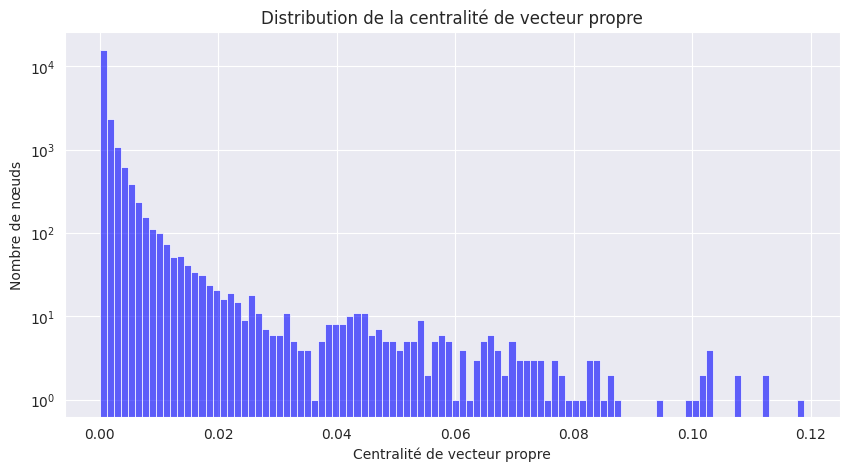

In [39]:
# eigenvector centrality

eigenvector_centrality = nx.eigenvector_centrality(graph)

# Afficher les 5 nœuds les plus centraux
top_nodes = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 nœuds par centralité de vecteur propre :")
for node, centrality in top_nodes:
    print(f"Nœud {node} -> Centralité : {centrality:.4f}")
    
# histogram
plt.figure(figsize=(10, 5))
sns.histplot(list(eigenvector_centrality.values()), bins=100, color='blue', log_scale=False, alpha=0.6)
plt.xlabel("Centralité de vecteur propre")
plt.yscale('log')
plt.ylabel("Nombre de nœuds")
plt.title("Distribution de la centralité de vecteur propre")
plt.show()

### betweenness centrality

In [ ]:
betweenness_centrality = nx.betweenness_centrality(graph)

# Afficher les 5 nœuds les plus centraux
top_nodes = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 nœuds par intermédiarité :")
for node, centrality in top_nodes:
    print(f"Nœud {node} -> Centralité : {centrality:.4f}")
    
# histogram
plt.figure(figsize=(10, 5))
sns.histplot(list(betweenness_centrality.values()), bins=300, color='blue', log_scale=False, alpha=0.6)
plt.xlabel("Centralité d'intermédiarité")
plt.yscale('log')
plt.ylabel("Nombre de nœuds")
plt.title("Distribution de la centralité d'intermédiarité")
plt.show()